### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Available traces

In [41]:
%ls ../traces

cjpeg.nocache.csv  matmul_float_16.csv  search_large.csv
crc_large.csv      matmul_int_16.csv    susan_edge_large.csv
dijkstra.csv       matmul_int_32.csv    susan_edge_small.csv
fft.csv            qsort_small.csv      susan_smooth_small.csv


### Select trace data frame

In [2]:
col_names = ['cycle', 'op', 'width', 'addr']
df = pd.read_csv('../traces/fft.csv', names=col_names)

### Total number of Loads and Stores

In [3]:
df.groupby('op').cycle.count()

op
LD    4147958
ST    3546190
Name: cycle, dtype: int64

## Set up blocks

Address space is divided in bloks of N words with $N \in [1, 2, 4 .. 512]$

In [4]:
block_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512] # number of 32bit words
for bs in block_sizes:
    shift_val = int(np.log2(bs*4)) 
    df[f'block_{bs}'] = np.right_shift(df.addr & 0xffffffff, shift_val)

#df['page_1K'] = np.right_shift(df.addr, int(np.log2(256*4)))
#df['page_2K'] = np.right_shift(df.addr, int(np.log2(512*4)))

### Number of LD/ST per address

In [6]:
block1_op_count = df[['cycle','block_1','op']].groupby(['block_1', 'op']).size().unstack(fill_value=0)

In [7]:
block1_op_count.columns.name = None
block1_op_count.reset_index(inplace=True)
block1_op_count.tail()

block_1  LD  ST
1631  16776192   1   0
1632  16776194   1   0
1633  16776195   1   0
1634  16776207   4   0
1635  16776208   3   0

### Mark first occurrence

In [8]:
df['first_use'] = ~df.block_1.duplicated(keep='first')

### Mark last occurrence

In [9]:
df['last_use'] = ~df.block_1.duplicated(keep='last')

### Add intervals

In [10]:
cycle_sizes = [6, 7]
for cs in cycle_sizes:
    df[f'interval_{cs}'] = np.array((df.cycle // 10**cs), dtype=int)

In [11]:
df.groupby('interval_7').count()

cycle       op    width     addr  block_1  block_2  block_4  \
interval_7                                                                  
0            867211   867211   867211   867211   867211   867211   867211   
1            857641   857641   857641   857641   857641   857641   857641   
2            864920   864920   864920   864920   864920   864920   864920   
3           1606432  1606432  1606432  1606432  1606432  1606432  1606432   
4           1608929  1608929  1608929  1608929  1608929  1608929  1608929   
5           1604245  1604245  1604245  1604245  1604245  1604245  1604245   
6            284770   284770   284770   284770   284770   284770   284770   

            block_8  block_16  block_32  block_64  block_128  block_256  \
interval_7                                                                
0            867211    867211    867211    867211     867211     867211   
1            857641    857641    857641    857641     857641     857641   
2            864920    864920    864920    864920     864920     864920   
3           1606432   1606432   1606432   1606432    1606432    1606432   
4           1608929   1608929   1608929   1608929    1608929    1608929   
5           1604245   1604245   1604245   1604245    1604245    1604245   
6            284770    284770    284770    284770     284770     284770   

            block_512  first_use  last_use  interval_6  
interval_7                                              
0              867211     867211    867211      867211  
1              857641     857641    857641      857641  
2              864920     864920    864920      864920  
3             1606432    1606432   1606432     1606432  
4             1608929    1608929   1608929     1608929  
5             1604245    1604245   1604245     1604245  
6              284770     284770    284770      284770

### Operations per Interval

Divide execution trace in intervals of $10^6$ and $10^7$ cycles

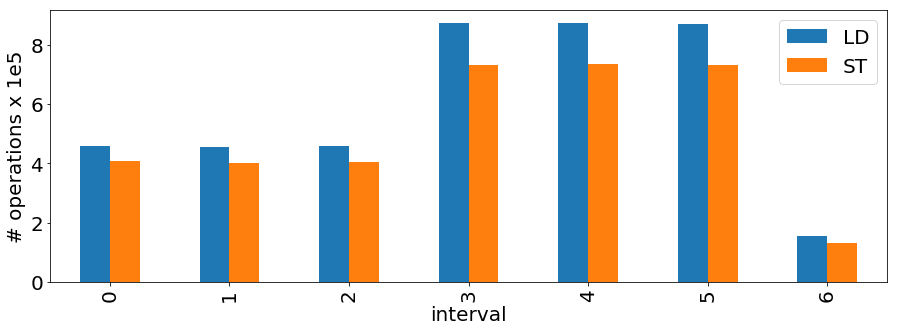

In [12]:
ax = df[['interval_7', 'op']].groupby('interval_7').op.value_counts().unstack().divide(1e5).plot.bar(figsize=(15,5), fontsize=20)
ax.set_xlabel('interval', fontsize=20)
ax.set_ylabel('# operations x 1e5', fontsize=20)
ax.legend(prop={'size':20})
plt.show()

## Oracle implementation

### Alive flag for oracle 
#### an address is alive if the next operation is a LD

Grouping by address:

    addr1:  ST  True
            LD  True
            LD  False
            ST  (True if next is LD)
            ...
            
            LD
    addr2:  op1
            ...
    addrM:  op1
            ...

In [13]:
op_by_block_1 = df[['block_1', 'op']].groupby('block_1', group_keys=False).op

In [14]:
df['oracle_alive'] = op_by_block_1.shift(-1) == 'LD'

In [15]:
df[['cycle','op','addr','oracle_alive']][df.addr == 156724]

cycle  op    addr  oracle_alive
131           822  LD  156724          True
133           830  LD  156724          True
217          1236  LD  156724          True
247          1389  LD  156724          True
309          1688  LD  156724          True
340          1833  LD  156724          True
371          1977  LD  156724          True
2571848  29894566  LD  156724          True
2593333  30031046  LD  156724          True
2593419  30031414  LD  156724          True
7693780  61782877  LD  156724         False
7693781  61782880  ST  156724          True
7693806  61783005  LD  156724         False
7693807  61783008  ST  156724          True
7693832  61783133  LD  156724         False
7693833  61783136  ST  156724          True
7693858  61783261  LD  156724         False
7693859  61783264  ST  156724          True
7693884  61783389  LD  156724         False
7693885  61783392  ST  156724          True
7693910  61783517  LD  156724         False
7693911  61783520  ST  156724          True
7694078  61784281  LD  156724         False
7694079  61784284  ST  156724         False

## Strategy 1: Address count per interval
### An address (block_1)  is counted if it is accessed in any way (LD/ST) during the interval

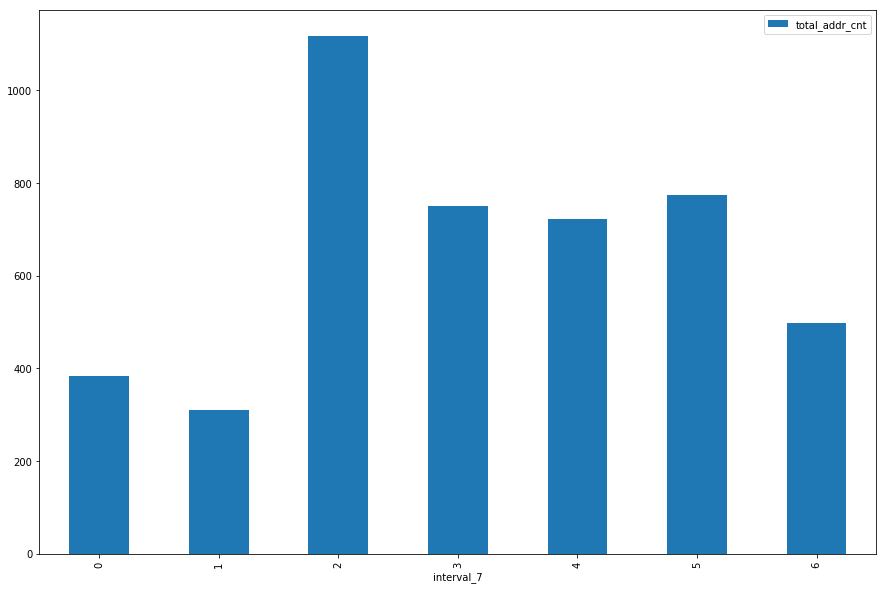

In [16]:
addr_cnt_per_interval = df[['interval_7', 'block_1']].drop_duplicates().groupby('interval_7').size()
addr_cnt_per_interval.to_frame('total_addr_cnt').plot(kind='bar', figsize=(15,10))
plt.show()

## Strategy 2: Modified in the current interval (Freezer)
### An address is counted if it was modified (ST access) at least once during the interval

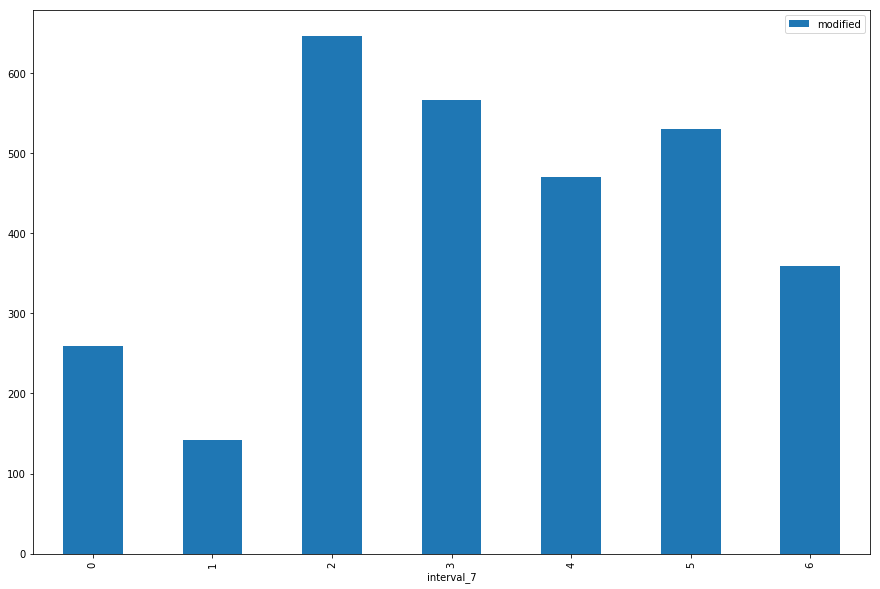

In [17]:
by_interval = df[['block_1', 'op', 'interval_7', 'oracle_alive']].groupby('interval_7')
modified_in_interval = by_interval.apply(lambda g: g[(g.op == 'ST')].block_1.nunique())
modified_in_interval.to_frame('modified').plot(kind='bar', figsize=(15,10))
plt.show()

## Strategy 3: Alive according to the Oracle (Impossible in real systems)

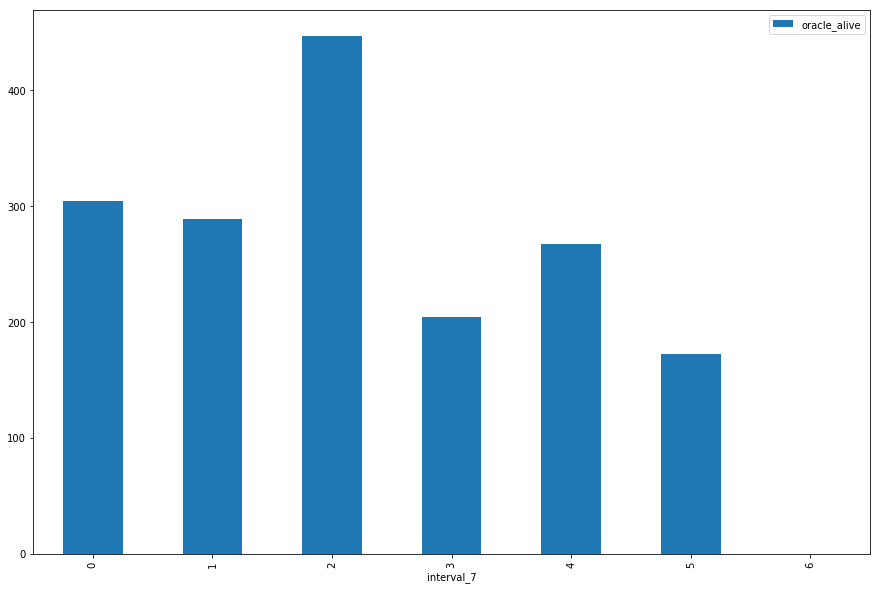

In [18]:
by_interval = df[['block_1', 'op', 'interval_7', 'oracle_alive']].groupby('interval_7')
oracle_alive = by_interval.apply(lambda g: g.loc[g.block_1.drop_duplicates(keep='last').index].oracle_alive.sum())
oracle_alive.to_frame('oracle_alive').plot(kind='bar', figsize=(15,10))
plt.show()

## Strategy 4: Oracle Alive and Modified (Impossible in real systems)

In [19]:
oracle_modified = by_interval.apply(lambda g: g[g.block_1.isin(g[g.op == 'ST'].block_1) & g.loc[g.block_1.drop_duplicates(keep='last').index].oracle_alive].block_1.count())

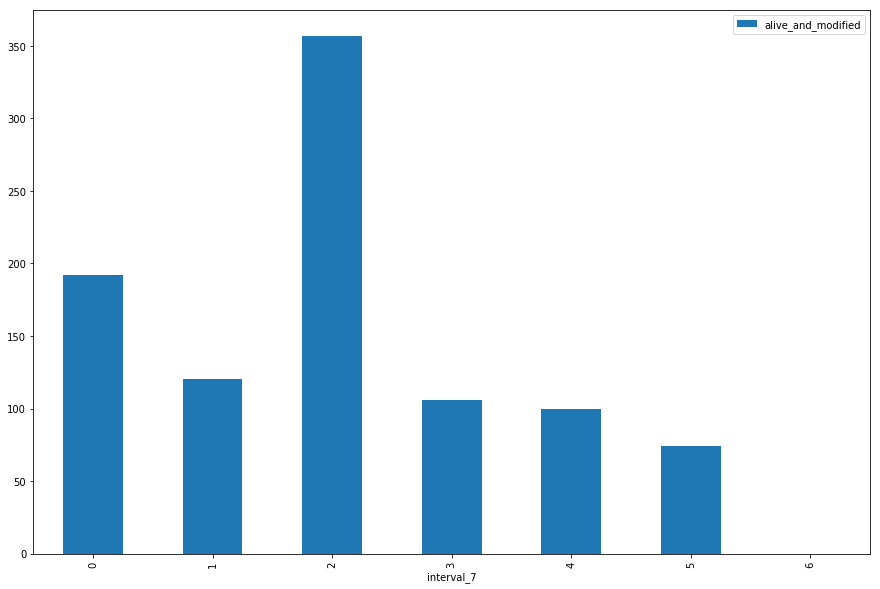

In [20]:
oracle_modified.to_frame('alive_and_modified').plot(kind='bar', figsize=(15,10))
plt.show()

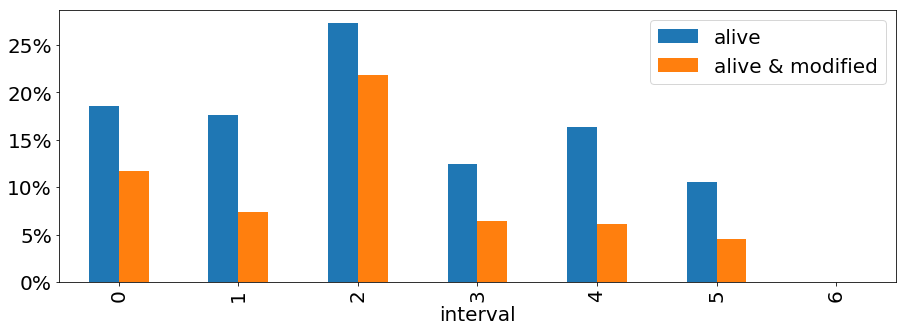

In [21]:
f = pd.DataFrame({'alive': oracle_alive, 'alive & modified': oracle_modified, 'modified': modified_in_interval})
ax = f.divide(len(df.block_1.unique()))[['alive', 'alive & modified']].plot.bar(figsize=(15,5), fontsize=20)
ax.legend(prop={'size':20})
#ax.set_ylabel('alive_words/total', fontsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
ax.set_xlabel('interval', fontsize=20)
plt.show()

### Number of words used throught the whole execution

In [22]:
len(df.block_1.unique())

1636

## Strategy 5: Full-Memory backup (Hibernus-like, word and page based)

In [23]:
hibernus_word = len(df.block_1.unique())
hibernus_page_512 = len(df.block_128.unique())*128
hibernus_page_1K = len(df.block_256.unique())*256 
hibernus_page_2K = len(df.block_512.unique())*512

In [24]:
hibernus_word

1636

In [25]:
hibernus_page_512

3200

In [26]:
hibernus_page_1K

3584

In [27]:
hibernus_page_2K

4608

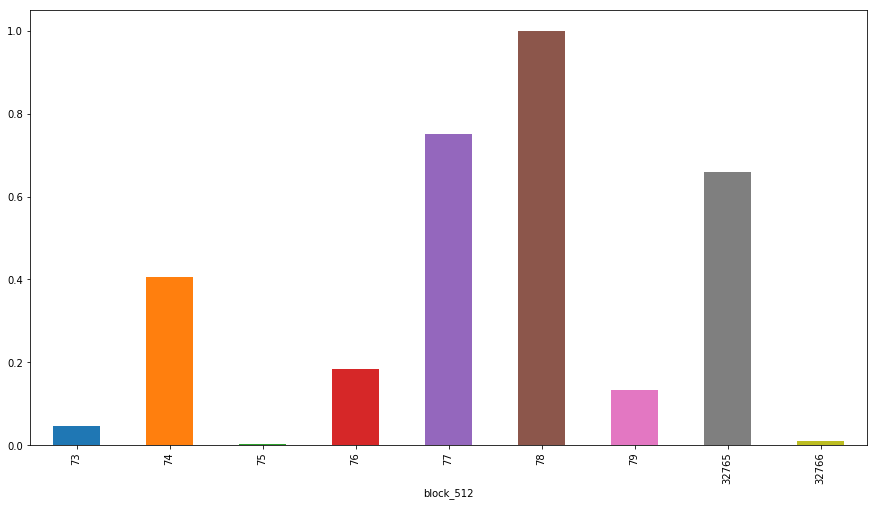

In [28]:
blk_op = df[['block_512', 'block_1']].drop_duplicates().groupby('block_512').block_1.size() # number of operations per address block
(blk_op/512).plot(kind='bar', figsize=(15,8)) #plot in percentage
plt.show()

## Backup size normalised on word-based Full-Memory (Number of Words) 

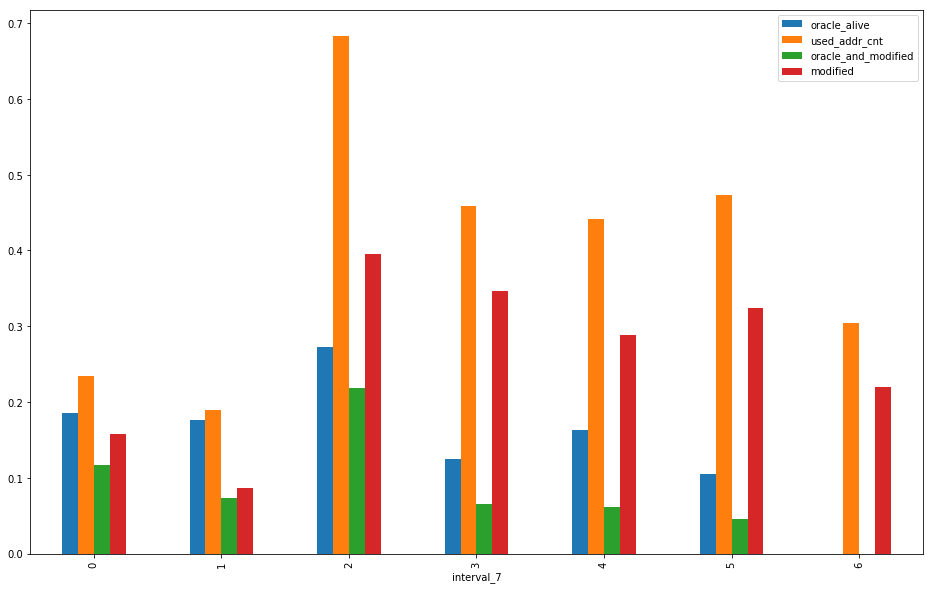

In [29]:
comp_df = pd.DataFrame(
    {
    #'hibernus_word': pd.Series(hibernus_word, index=oracle_alive.index),
    'oracle_alive': oracle_alive,
    'used_addr_cnt': addr_cnt_per_interval,
    'oracle_and_modified': oracle_modified,
    'modified': modified_in_interval}
    )
(comp_df/hibernus_word).plot(kind='bar', figsize=(16,10))
plt.show()

# Block based strategies

In [30]:
for bs in block_sizes:
    comp_df[f'block_{bs}'] = df[['interval_7', f'block_{bs}']].drop_duplicates().groupby('interval_7').count()*bs


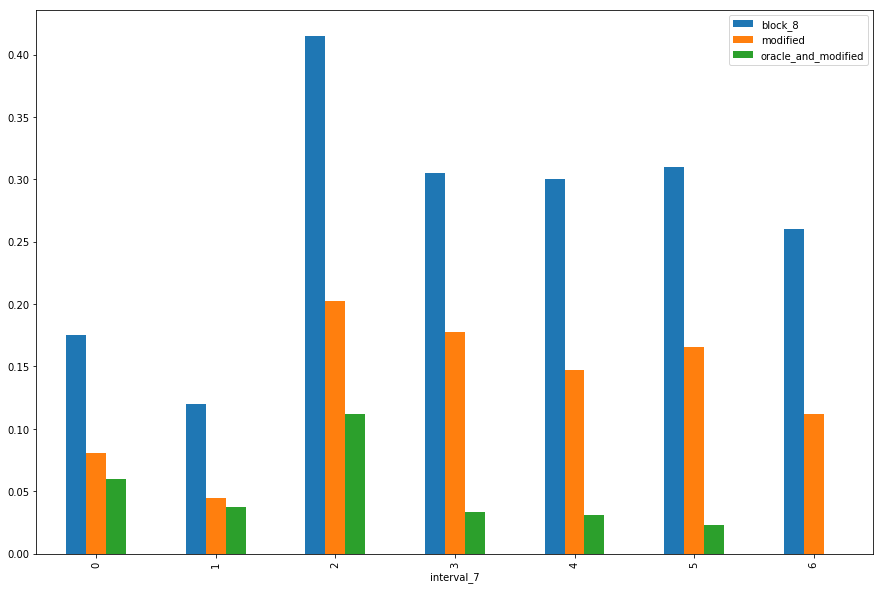

In [31]:
(comp_df[['block_8', 'modified', 'oracle_and_modified']] / hibernus_page_512).plot(kind='bar', figsize=(15,10))
plt.show()

## Compare Different Block sizes

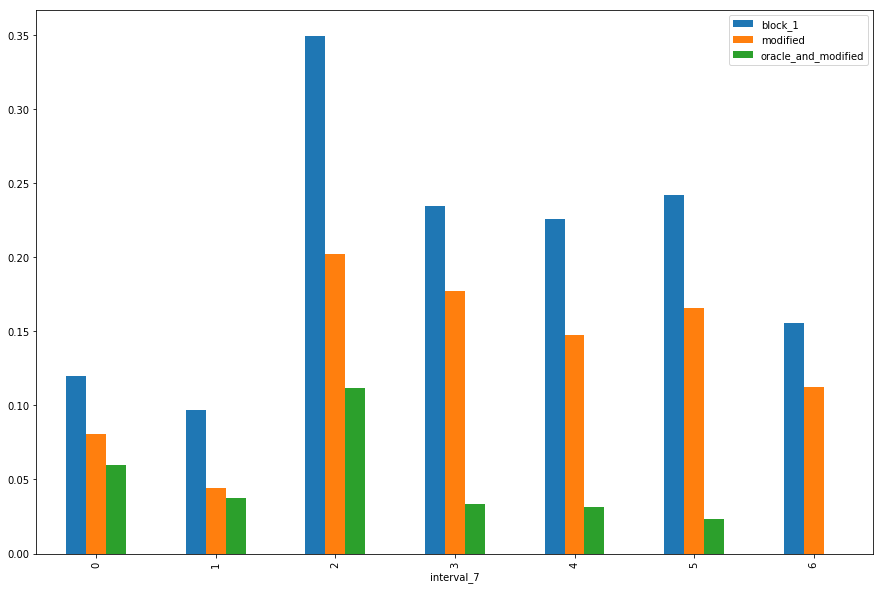

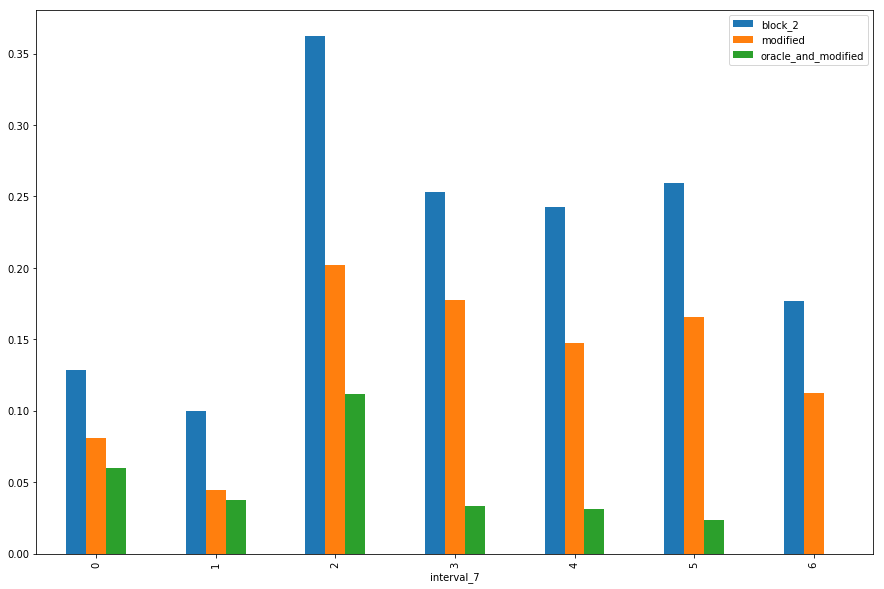

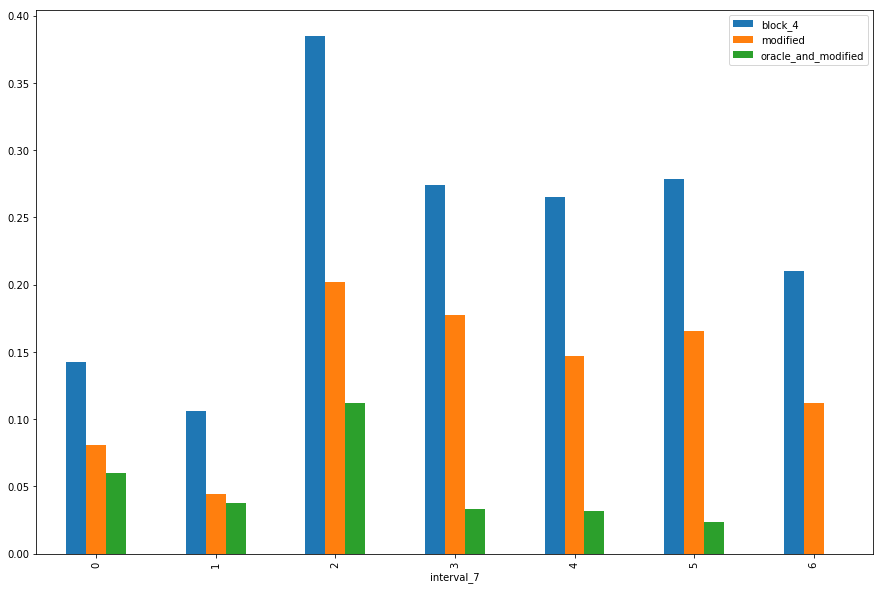

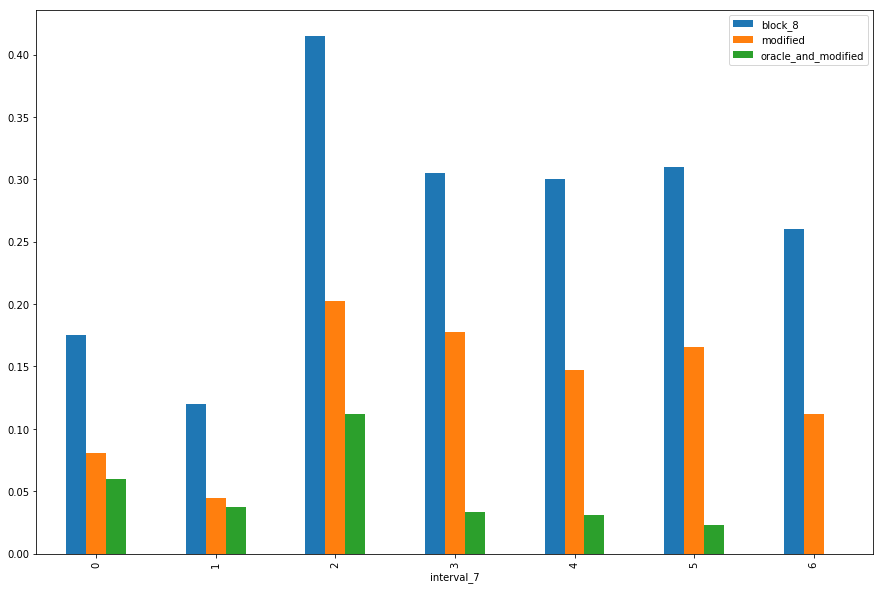

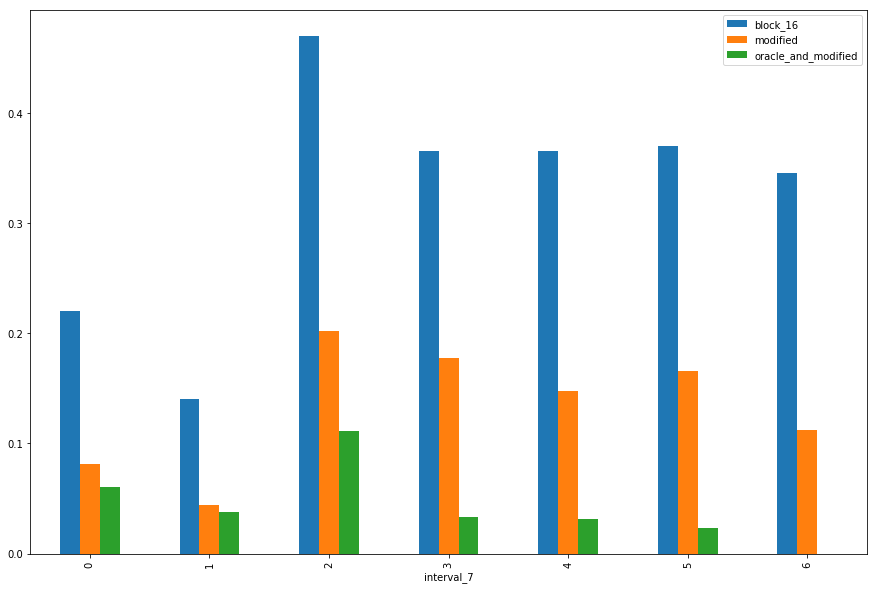

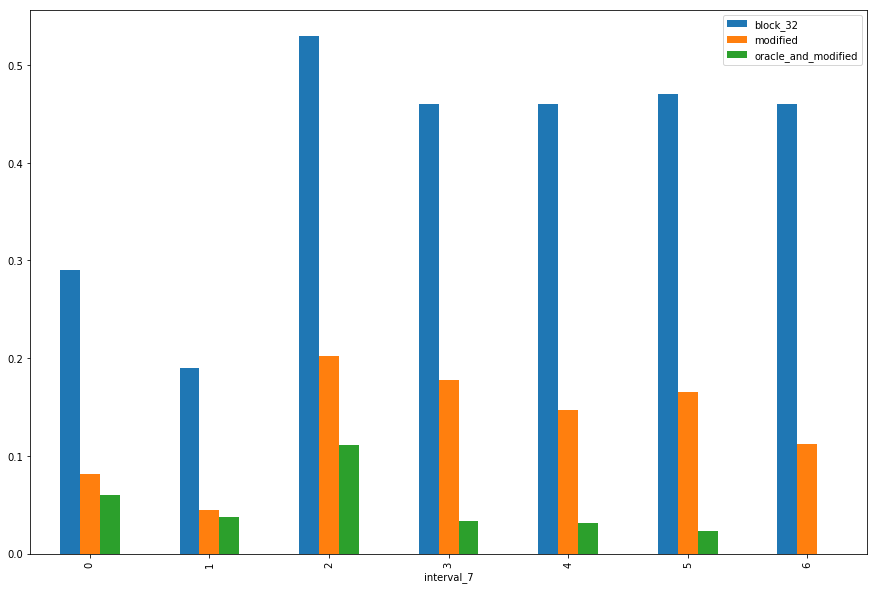

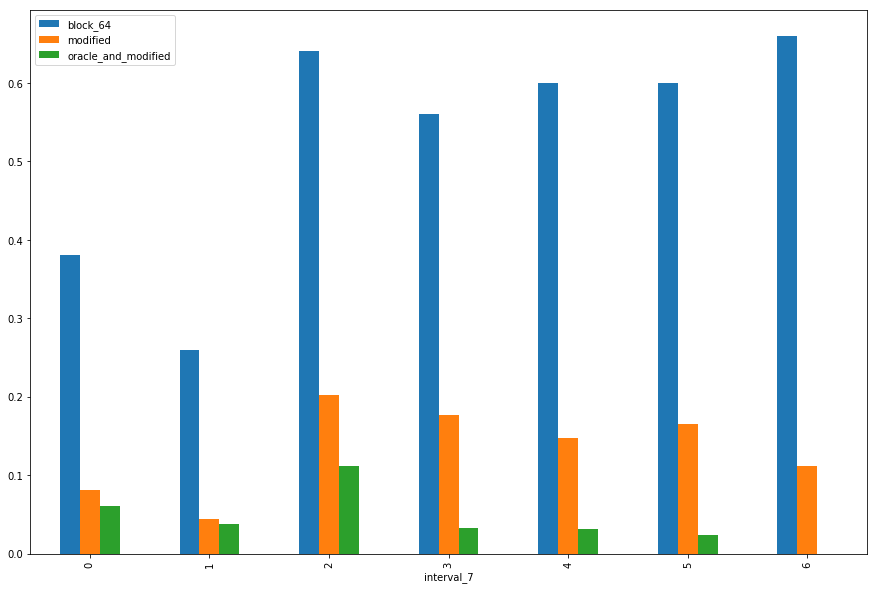

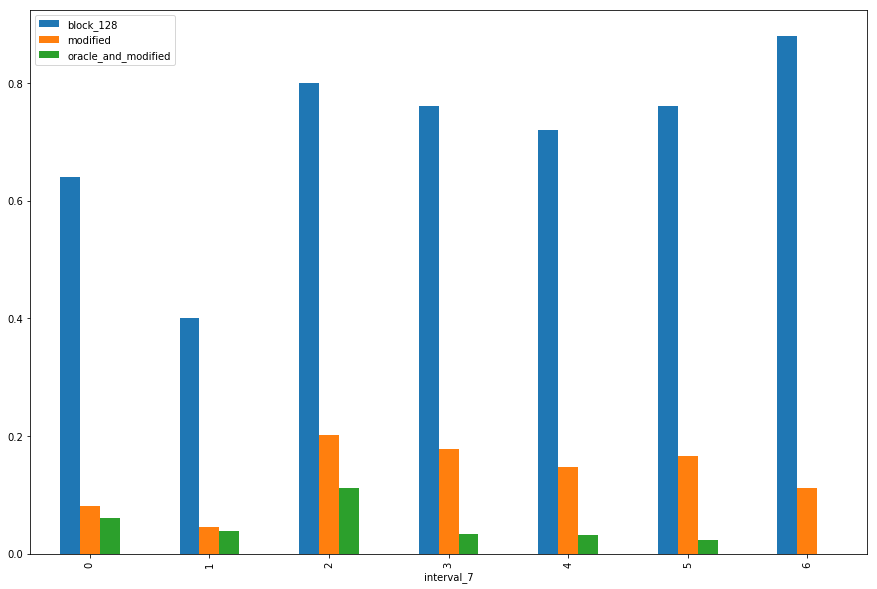

In [32]:
for bs in block_sizes[:-2]:
    (comp_df[[f'block_{bs}', 'modified', 'oracle_and_modified']] / hibernus_page_512).plot(kind='bar', figsize=(15,10))
    plt.show()

In [33]:
(comp_df[[f'block_{bs}' for bs in block_sizes]] / hibernus_page_512).mean()

block_1      0.203527
block_2      0.217589
block_4      0.237321
block_8      0.269286
block_16     0.325000
block_32     0.408571
block_64     0.528571
block_128    0.708571
block_256    0.857143
block_512    1.120000
dtype: float64

In [34]:
{f'block_{bs}': (comp_df[f'block_{bs}'] / (comp_df.modified)).mean() for bs in block_sizes}

{'block_1': 1.5865540304427588,
 'block_2': 1.6937020289124114,
 'block_4': 1.8513486287228176,
 'block_8': 2.123963079193765,
 'block_16': 2.5780881871461356,
 'block_32': 3.306490094060913,
 'block_64': 4.351727301357991,
 'block_128': 6.070256501143667,
 'block_256': 7.754816487528174,
 'block_512': 10.523395406385339}

In [35]:
(hibernus_page_512/comp_df.modified).mean()

9.603643835545958

In [36]:
(hibernus_word/comp_df.modified).mean()

4.90986291092287

In [37]:
df[[f'block_{bs}' for bs in block_sizes]].nunique()

block_1      1636
block_2       848
block_4       448
block_8       243
block_16      136
block_32       77
block_64       44
block_128      25
block_256      14
block_512       9
dtype: int64

## Block modified

In [38]:
for bs in block_sizes:
    tmp = df[[f'block_{bs}','interval_7', 'op']].groupby('interval_7')
    comp_df[f'block_{bs}_mod'] = bs*tmp.apply(lambda g: g.loc[g.op=='ST', f'block_{bs}'].nunique())

## Block count vs Block modified (Normalized wrt word Modified)

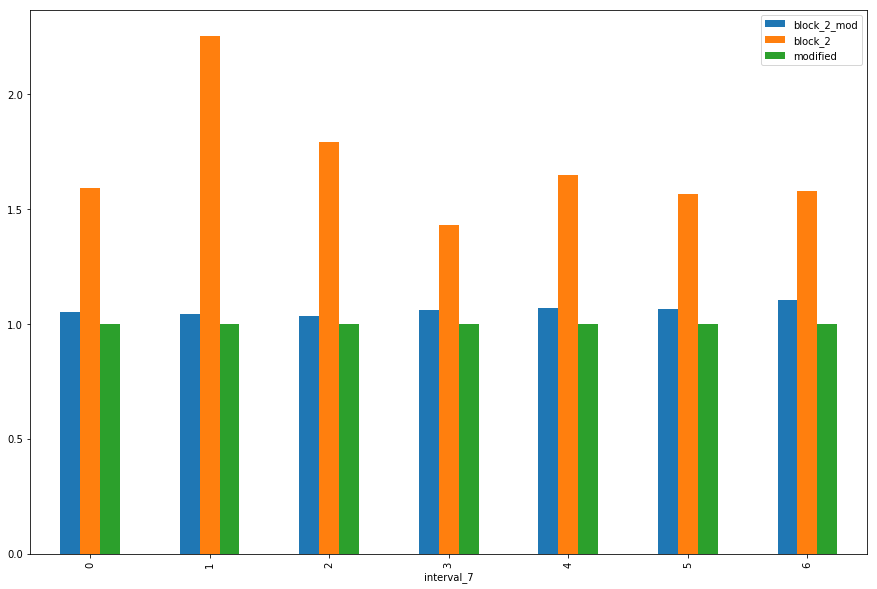

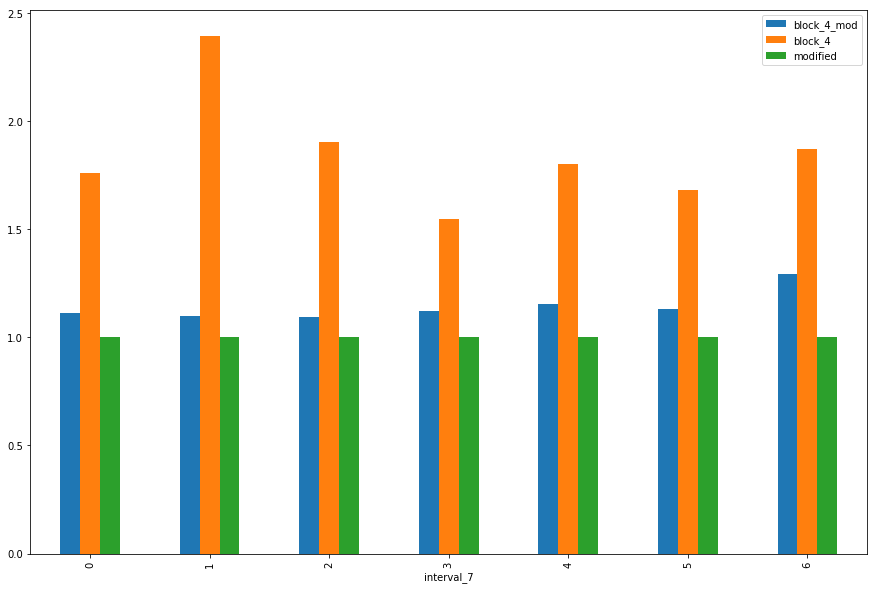

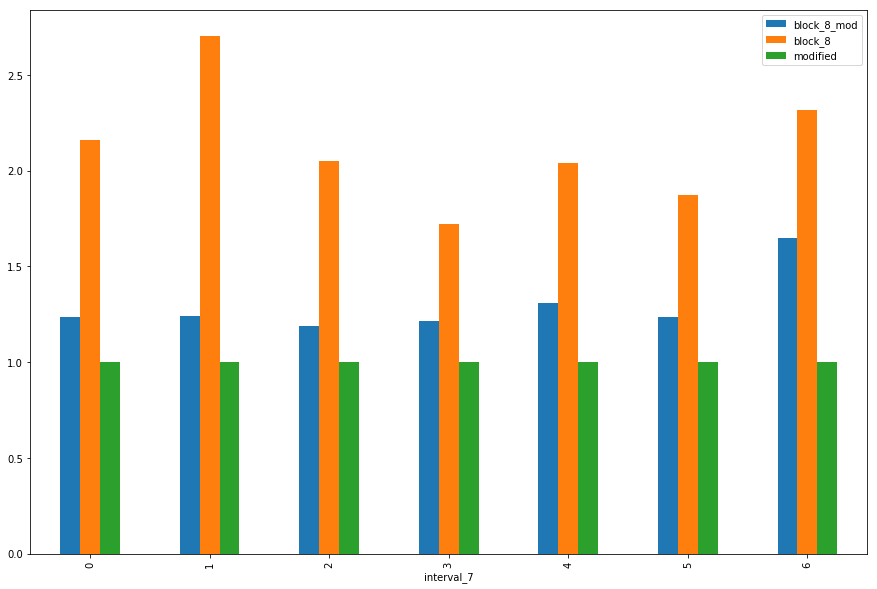

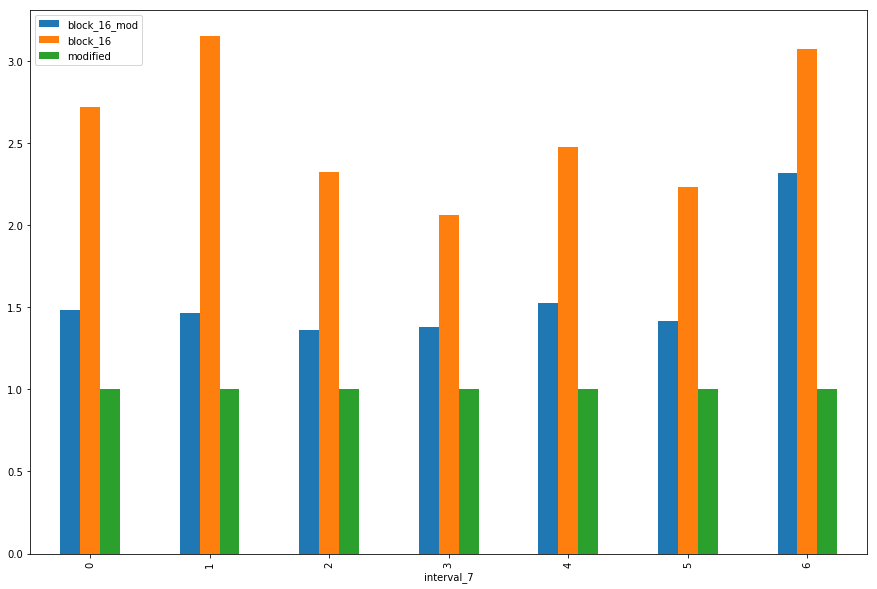

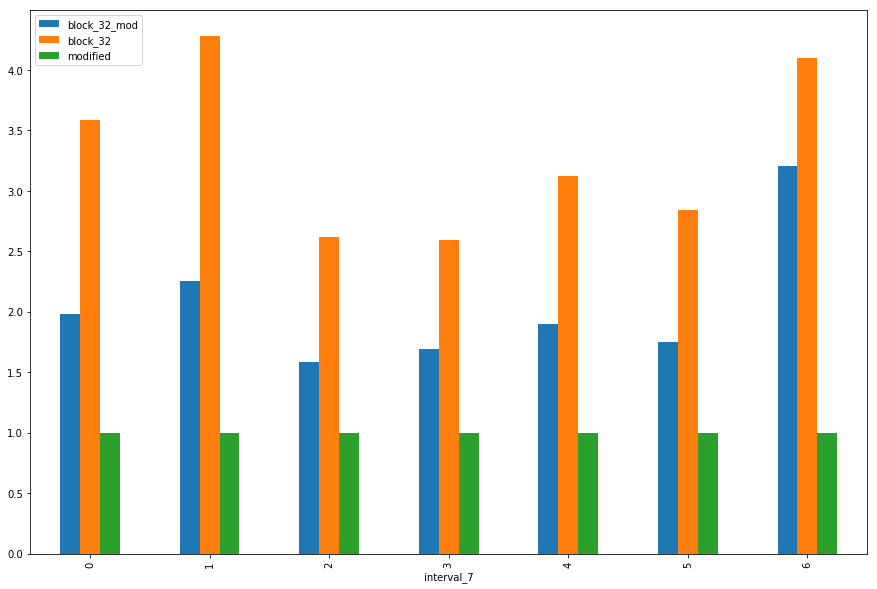

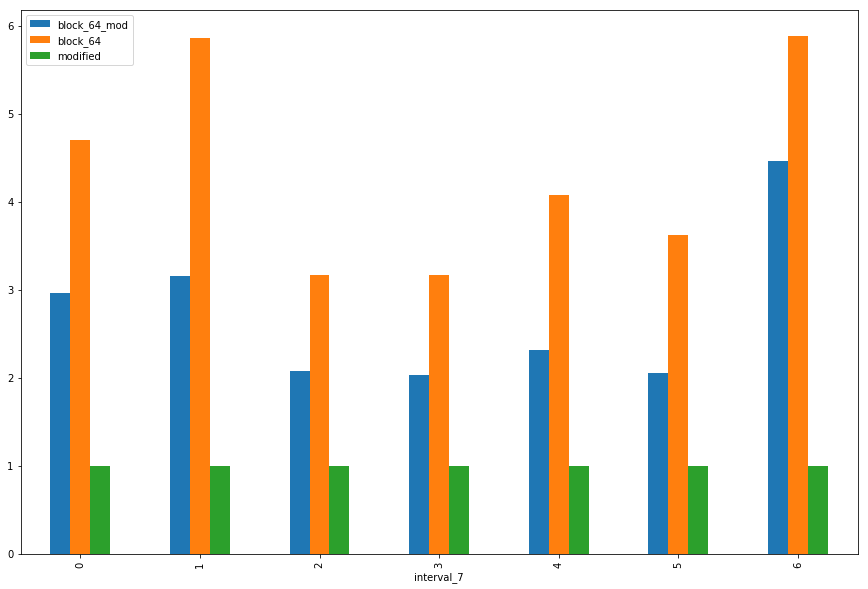

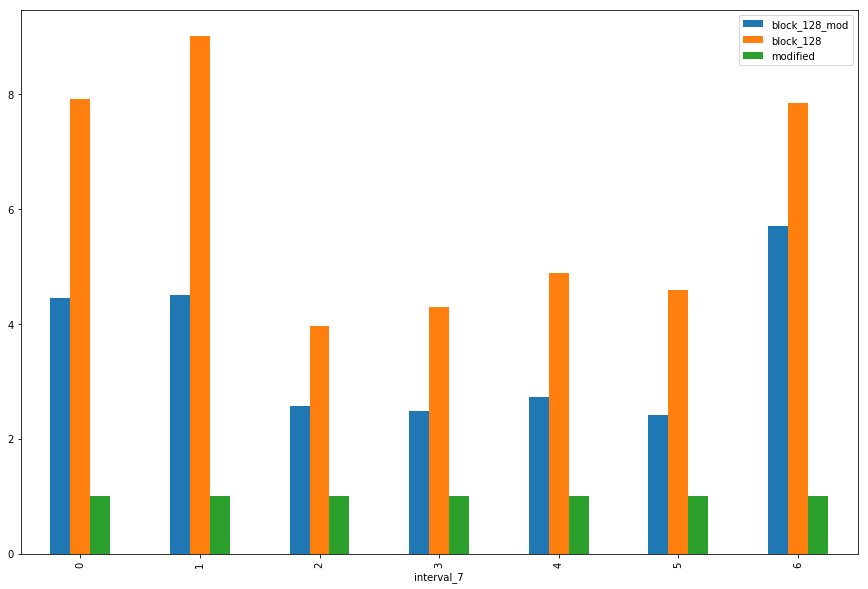

In [39]:
for bs in block_sizes[1:-2]:
    (comp_df[[f'block_{bs}_mod', f'block_{bs}', 'modified']].divide(comp_df.modified, axis='index')).plot(kind='bar', figsize=(15,10))
    plt.show()

## Block count vs Block Modified (Normalized wrt hibernus 512B page)

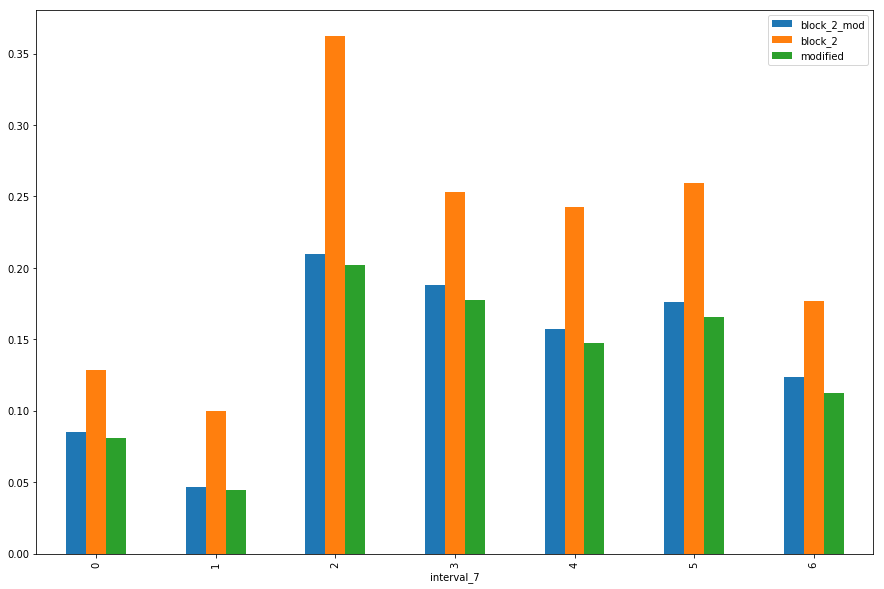

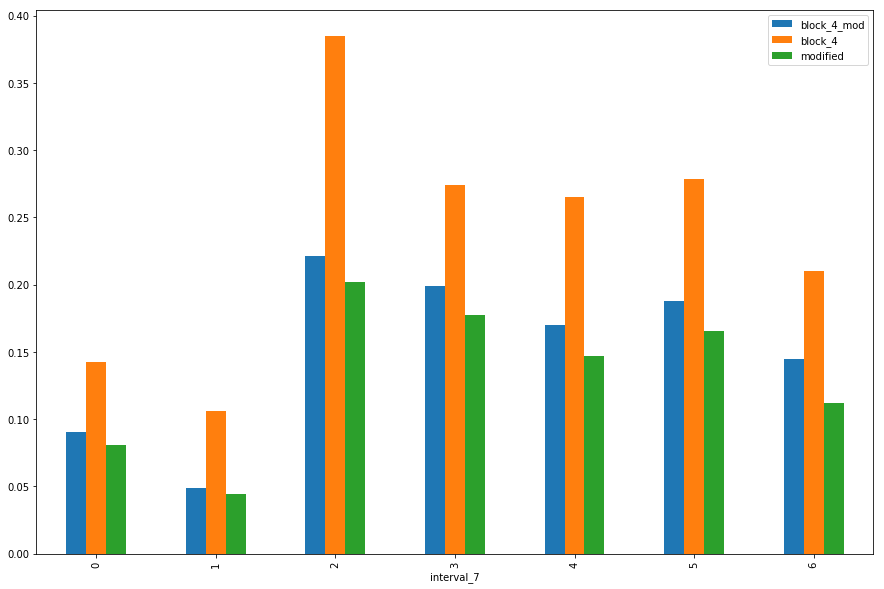

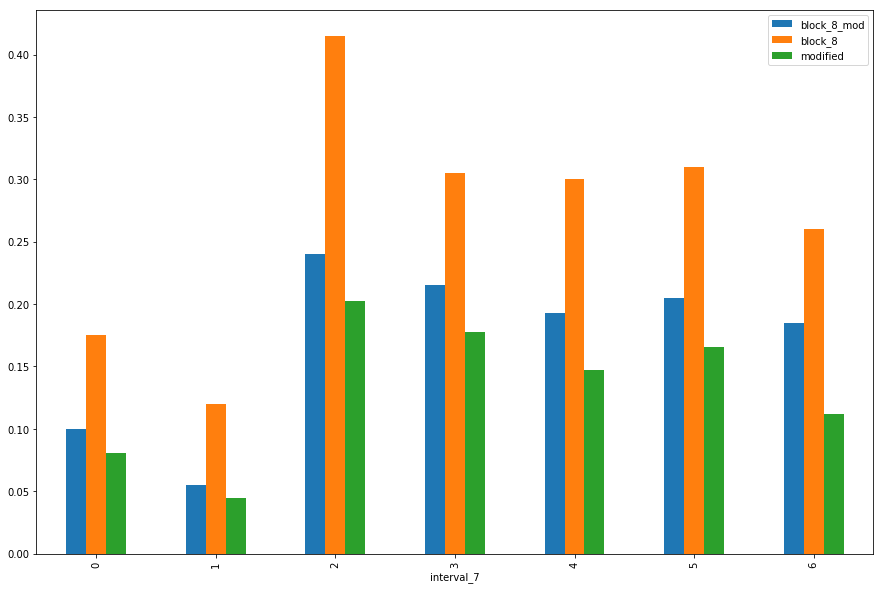

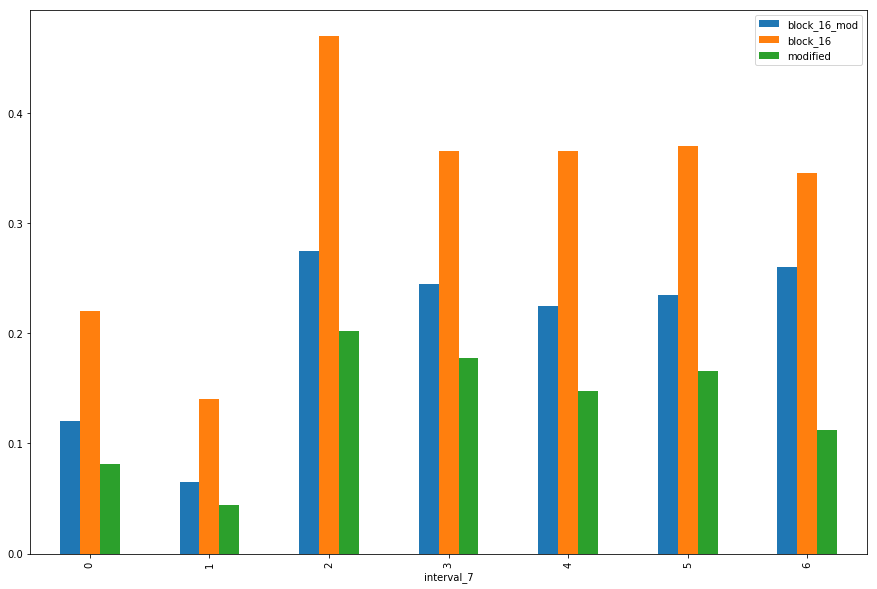

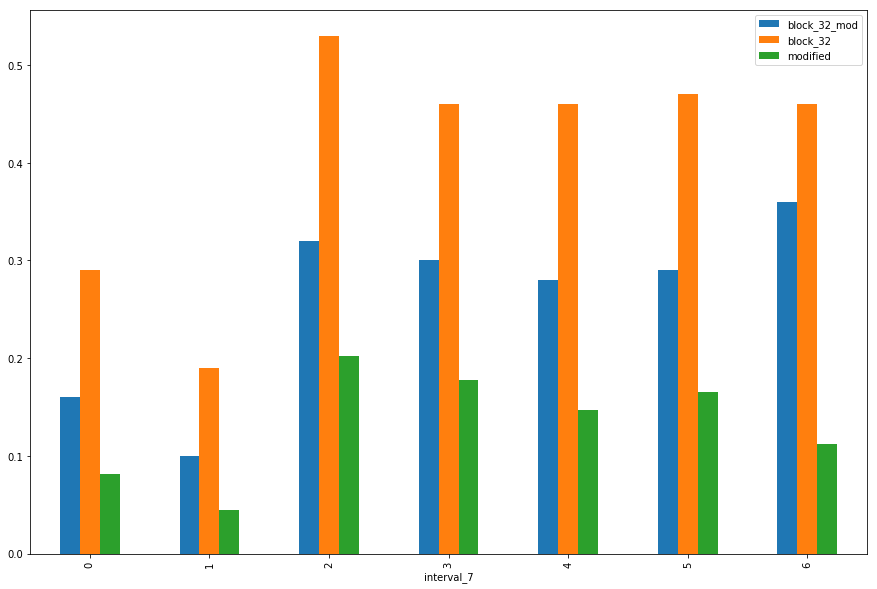

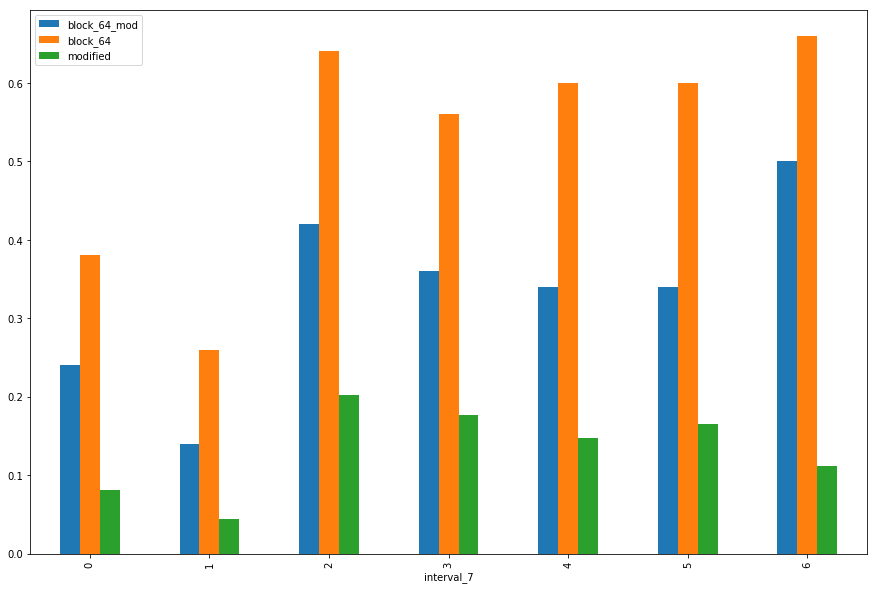

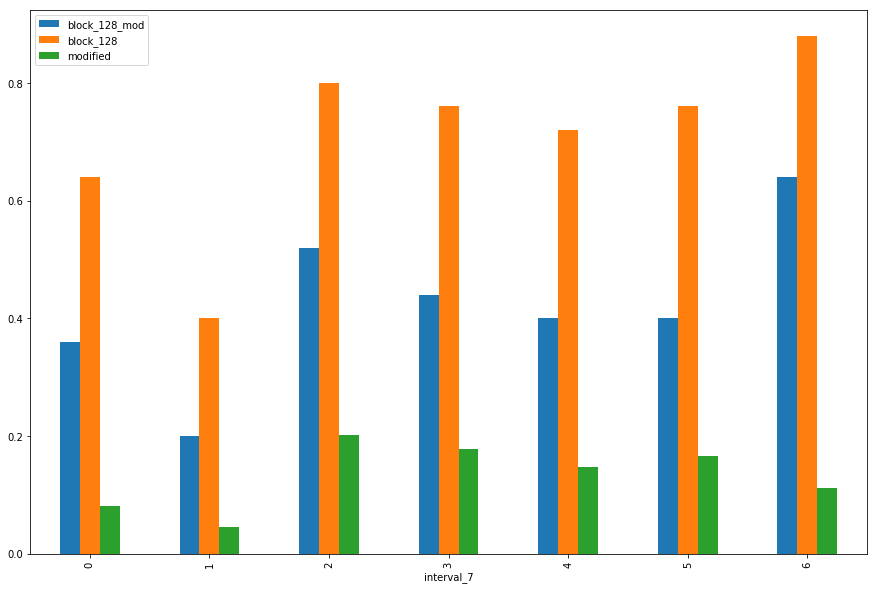

In [40]:
for bs in block_sizes[1:-2]:
    (comp_df[[f'block_{bs}_mod', f'block_{bs}', 'modified']].divide(hibernus_page_512)).plot(kind='bar', figsize=(15,10))
    plt.show()